# Introduction
DP requires a known MDP. Under this situation, the agent does not need to communicate with the env to get information about it. Instead, it can simply use DP to find out the optimal policy and value function. It is similar to a supervised learning task with given data distribution, where we can simply minimize the expected error in lieu of sampling data points.

However, this could be inrealistic to most RL scenarios, in which the MDP cannot be written expilicitly and the distribution is unknown. Under this setting, the agent has to interact with the environment and learn from sampled data. Such methods, as there is not enverionment model, are called model-free RL.

In this section we will learn 2 classic temporal difference methods that belongs to model-free RL, SARSA and Q-learning. Meanwhile, we also introduce a set of concepts: online learning vs. offline learning. Generally speaking, online learning force the agent to learn from data sampled from its current policy. Once the policy is updated, previous samples are no longer valid. On the other hand, offline learning collects previous sampled data into a replay pool for further utilization. Therefore, offline learning is usually better in utilizing historical data, and has a smaller sample complexity (number of samples required to reach convergence). 

# Temporal Difference
Temporal Difference (TD) is a method to evaluate the value function that combines the ideas of Monte Calro (MC) methods and DP. TD is similar to MC in a way that they learn from data samples without the need to know the environment. TD resembles DP by estimating current value functions using later states' values according to the Bellman equation.

Review the update of value functions in MC: $$V(s_t) \leftarrow V(s_t) + \alpha[G_t - V(s_t)]$$ where we replace $\frac{1}{N(s)}$ with $\alpha$, a constant represents the step of the update. MC must wait until the episode ends to calculate $G_t$, while TD can calculate it once a step ends. 

Instead of taking the expectation of the following values, TD estimates the return of current state by current reward plus next state value (discounted): $$V(s_t) \leftarrow V(s_t) + \alpha[r_t + \gamma V(s_{t+1}) - V(s_t)], $$

among which $r_t + \gamma V(s_{t+1}) - V(s_t)$ is called TD error. 

Here is why you can replace $G_t$ with $r_t + \gamma V(s_{t+1})$:

$$V_\pi(s) = \mathbb{E}_\pi[G_t | S_t = s] \\ \quad = \mathbb{E}_\pi[\sum_{k=0}^\infty \gamma^k R_{t+k}| S_t = s] \\ \quad = \mathbb{E}_\pi[R_t + \gamma \sum_{k=0}^\infty \gamma^k R_{t+k+1} | S_t = s] \\ \quad = \mathbb{E}_\pi[R_t + \gamma V(s_{t+1}) | S_t = s]$$


# Sarsa Algorithm
With our TD estimation, it is nature for us to think if there is a way we can do RL resembling policy iteration. For policy evaluation, we can directly use TD estimation. But what should we do for policy improvement without reward function and state transformation functions? The answer is to use TD estimation for the action value function $Q$: $$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha[r(s_t, a_t) + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]$$

Then we can choose the best action greedily: $\arg \max_a(Q(s, a))$. It seems to be a complete algorithm now: use greedy algorithm to interact with the environment, and then use the sampled data from interation to update the state value function by TD estimation. 

However, there exists something to think before we start our implementation. First, an accurate estimation requires great amount of data samples. But, recall what we do in our value iteration algorithm. Actually we do not need it to be very accurate before we update our policy, the idea of which is call the generalized policy iteration. Second, if we use the greedy selection, some actions may naver appear in our sampled data, in which case we cannot estimate those action values and thus cannot guarantee the updated policy is better than the old one. If I may remind you of what we do in the bandit problem, usually we can replace greedy with $\epsilon$-greedy. In our case, we have the formula below: $$\pi(a|s) = \begin{cases} \frac{\epsilon}{|\mathcal{A}|} + 1 - \epsilon \text{, if } a = \arg \max_{a' \in \mathcal{A}} Q(s, a') \\ \frac{\epsilon}{|\mathcal{A}|} \text{, otherwise}\end{cases}$$

Now, we have the SARSA algorithm. This alogirthm got its name by what its update requires: current state $s$, current action $a$, reward $r$, next state $s'$, and next action $a'$. Below is the full descrition of Sarsa:

- Init $Q(s, a)$
- for $e \leftarrow 1$ to $E$ do:
    - get start state $s$
    - choose the action $a$ by $\epsilon$-greedy
    - for $t \leftarrow 1$ to $T$ do:
        - get $r, s'$ from env
        - choose $a'$ by $\epsilon$-greedy
        - $Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)]$
        - $s \leftarrow s'$, $a \leftarrow a'$
    - end for
- end for

Now, let's try Sarsa in cliff walking! Notice we have some different implementation this time to better interact. 

In [8]:
!pip install tqdm

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

Then let's implement Sarsa. We mainly maintain a table $Q_table()$ to store all the action values under current policy. The interaction is done via $\epsilon$-greedy. Update is done by TD. In default all the actions at the end state becomes 0, which means they will not be updated once initialized as 0.

In [12]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
       # TODO: finish the epsilon-greedy action chosen
        rand = np.random.random()
        if rand > self.epsilon:
            action_vals = [self.Q_table[state, a] for a in range(self.n_action)]
            action = np.argmax(action_vals)
        else:
            action = np.random.choice(range(self.n_action))
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        # TODO: update Q table
        self.Q_table[s0, a0] += self.alpha *(r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0])

Now let us run Sarsa to see the results.

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 7205.97it/s, episode=500, return=-18.900] 


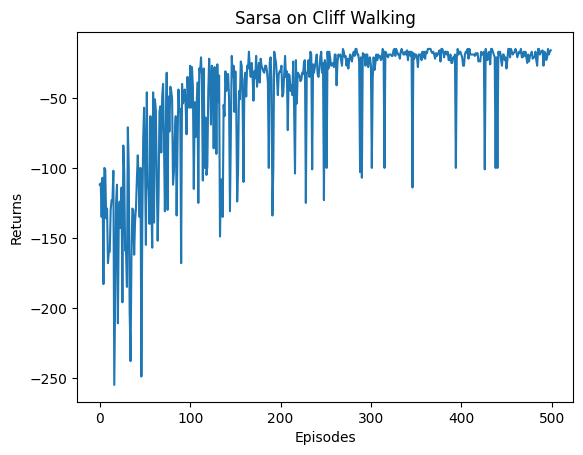

In [13]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                # TODO: fill in the blank
                episode_return += reward # record the true reward
                next_action = agent.take_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

The code below illustrates the policy learned by Sarsa.

In [14]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


# Multi-step Sarsa

MC uses all rewards and no values to estimate current values, so it is unbiased but has high variance. TD, on the other hand, adopts the current reward and next state value, which is biased with low variance. Can we combine the advantages of the two and have a less-biased, low-variant esitmation? The answer for that is multi-step TD. 

From our proof of why TD estimation works, it is easy to observe that: 

if $V(s_t) \leftarrow V(s_t) + \alpha[r_t + \gamma V(s_{t+1}) - V(s_t)]$ works, 

then $V(s_t) \leftarrow V(s_t) + \alpha[r_t + \gamma r_{t+1} + \gamma^2V(s_{t+1}) - V(s_t)] $ also works. 

If we can get $n$ steps' rewards, we will have $$V(s_t) \leftarrow V(s_t) + \alpha[\sum_{k=0}^{n-1} \gamma^{k}r_{t+k} + \gamma^{n}V(s_{t+n}) - V(s_t)]$$

Natually, we find a multi-step Sarsa algorithm that has lower bias and lower variance:
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha[\sum_{k=0}^{n-1} \gamma^{k}r_{t+k} + \gamma^{n}Q(s_{t+n}, a_{t+n}) - Q(s_t, a_t)]$$


Now, let us implement an n-step Sarsa alogrithm.

In [23]:
class nstep_Sarsa:
    """n step Sarsa算法 """
    def __init__(self, ncol, nrow, n_step, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_step = n_step
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.a_list = [] # to store the actions taken for estimation
        self.s_list = [] # to store the steps taken for estimation
        self.r_list = [] # to store the rewards taken for estimation

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
       # TODO: finish the epsilon-greedy action chosen
        rand = np.random.random()
        if rand > self.epsilon:
            action_vals = [self.Q_table[state, a] for a in range(self.n_action)]
            action = np.argmax(action_vals)
        else:
            action = np.random.choice(range(self.n_action))
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, sn, an, done):
        # TODO: update Q table
        self.s_list.append(s0)
        self.a_list.append(a0)
        self.r_list.append(r)

        epi_len = len(self.s_list)

        if epi_len == self.n_step:
            G = self.Q_table[sn, an]
            for i in reversed(range(self.n_step)):
                G = self.gamma * G + self.r_list[i]
                if done and i > 0: # if the episode ends, the last few steps should alsp be updated
                    si = self.s_list[i]
                    ai = self.a_list[i]
                    self.Q_table[si, ai] += self.alpha * (G - self.Q_table[si, ai])
            # n-step Sarsa update
            s = self.s_list.pop(0)
            a = self.a_list.pop(0)
            self.r_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])

        if done:
            self.s_list = []
            self.a_list = []
            self.r_list = []
            

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 9656.73it/s, episode=500, return=-19.100] 


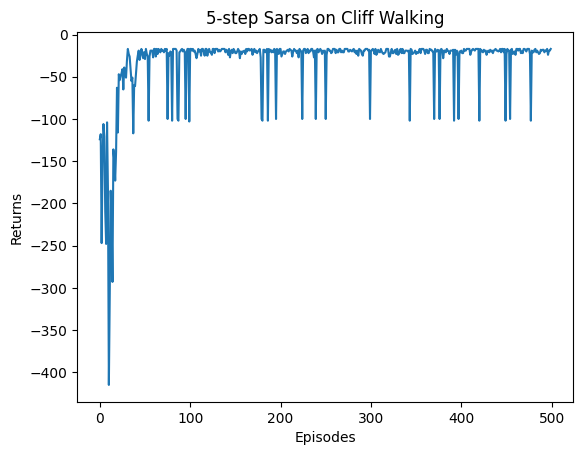

In [24]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
n_step = 5
agent = nstep_Sarsa(ncol, nrow, n_step, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                # TODO: fill in the blank
                episode_return += reward # record the true reward
                next_action = agent.take_action(next_state)
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [25]:
action_meaning = ['^', 'v', '<', '>']
print('5-step Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5-step Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


# Q-learning
Sarsa updates the action values based on actual sampled data. But if our target is the optimal action value, why don't we just update $Q$ by the optimal action under our current estimation instead of sampling one that may not by optimal? This is the idea of Q-learning: $$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha * [r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]$$

The algorithm looks like this:
- Init Q(s, a)
- for episode $e \leftarrow 1$ to $\mathcal{E}$ do:
    - sample initial state $s$
    - for timestep $t \leftarrow 1$ to $\mathcal{T}$ do:
        - get $a$ by $\epsilon$-greedy($s$)
        - get $r, s'$ from env (notice here we do not need to sample the next action! We simply use the best up till now.)
        - $Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha * [r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]$
        - $s \leftarrow s'$
    - end for
- end for

Now let's implement Q-learning.


In [ ]:
class QLearning:
    """ QLearning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.random.random([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
       # TODO: finish the epsilon-greedy action chosen
        rand = np.random.random()
        if rand > self.epsilon:
            action_vals = [self.Q_table[state, a] for a in range(self.n_action)]
            action = np.argmax(action_vals)
        else:
            action = np.random.choice(range(self.n_action))
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        # TODO: update Q table
        action_vals = []
        for a in range(self.n_action):
            action_vals.append(self.Q_table[s1, a])
        self.Q_table[s0, a0] += self.alpha *(r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0, a0])

In [34]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                # TODO: fill in the blank
                episode_return += reward # record the true reward
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

Iteration 0:   2%|▏         | 1/50 [00:35<28:50, 35.31s/it]


KeyboardInterrupt: 